In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from astropy.table import Table

In [6]:
# DOWNLOAD THE FITS FILE FROM www.sdss.org/dr16/algorithms/qso_catalog/ AND PUT INTO THE DIRECTORY BELOW
# filepath = '/quirky_quasars/data/catalogues/DR16Q_v4.fits'
filepath = '/disk1/hrb/python/data/catalogues/qsos/dr16q/DR16Q_v4.fits' # Leave this commented out.

In [7]:
dr16q = Table.read(filepath)

In [8]:
# Let's look at the first 5 rows
dr16q[:5]

SDSS_NAME,RA,DEC,PLATE,MJD,FIBERID,AUTOCLASS_PQN,AUTOCLASS_DR14Q,IS_QSO_QN,Z_QN,RANDOM_SELECT,Z_10K,Z_CONF_10K,PIPE_CORR_10K,IS_QSO_10K,THING_ID,Z_VI,Z_CONF,CLASS_PERSON,Z_DR12Q,IS_QSO_DR12Q,Z_DR7Q_SCH,IS_QSO_DR7Q,Z_DR6Q_HW,Z_DR7Q_HW,IS_QSO_FINAL,Z,SOURCE_Z,Z_PIPE,ZWARNING,OBJID,Z_PCA,ZWARN_PCA,DELTACHI2_PCA,Z_HALPHA,ZWARN_HALPHA,DELTACHI2_HALPHA,Z_HBETA,ZWARN_HBETA,DELTACHI2_HBETA,Z_MGII,ZWARN_MGII,DELTACHI2_MGII,Z_CIII,ZWARN_CIII,DELTACHI2_CIII,Z_CIV,ZWARN_CIV,DELTACHI2_CIV,Z_LYA,ZWARN_LYA,DELTACHI2_LYA,Z_LYAWG,Z_DLA [5],NHI_DLA [5],CONF_DLA [5],BAL_PROB,BI_CIV,ERR_BI_CIV,AI_CIV,ERR_AI_CIV,BI_SIIV,ERR_BI_SIIV,AI_SIIV,ERR_AI_SIIV,BOSS_TARGET1,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,ANCILLARY_TARGET1,ANCILLARY_TARGET2,NSPEC_SDSS,NSPEC_BOSS,NSPEC,PLATE_DUPLICATE [74],MJD_DUPLICATE [74],FIBERID_DUPLICATE [74],SPECTRO_DUPLICATE [74],SKYVERSION,RUN_NUMBER,RERUN_NUMBER,CAMCOL_NUMBER,FIELD_NUMBER,ID_NUMBER,LAMBDA_EFF,ZOFFSET,XFOCAL,YFOCAL,CHUNK,TILE,PLATESN2,PSFFLUX [5],PSFFLUX_IVAR [5],PSFMAG [5],PSFMAGERR [5],EXTINCTION [5],M_I,SN_MEDIAN_ALL,GALEX_MATCHED,FUV,FUV_IVAR,NUV,NUV_IVAR,UKIDSS_MATCHED,YFLUX,YFLUX_ERR,JFLUX,JFLUX_ERR,HFLUX,HFLUX_ERR,KFLUX,KFLUX_ERR,W1_FLUX,W1_FLUX_IVAR,W1_MAG,W1_MAG_ERR,W1_CHI2,W1_FLUX_SNR,W1_SRC_FRAC,W1_EXT_FLUX,W1_EXT_FRAC,W1_NPIX,W2_FLUX,W2_FLUX_IVAR,W2_MAG,W2_MAG_ERR,W2_CHI2,W2_FLUX_SNR,W2_SRC_FRAC,W2_EXT_FLUX,W2_EXT_FRAC,W2_NPIX,FIRST_MATCHED,FIRST_FLUX,FIRST_SNR,SDSS2FIRST_SEP,JMAG,JMAG_ERR,JSNR,JRDFLAG,HMAG,HMAG_ERR,HSNR,HRDFLAG,KMAG,KMAG_ERR,KSNR,KRDFLAG,SDSS2MASS_SEP,2RXS_ID,2RXS_RA,2RXS_DEC,2RXS_SRC_FLUX,2RXS_SRC_FLUX_ERR,SDSS2ROSAT_SEP,XMM_SRC_ID,XMM_RA,XMM_DEC,XMM_SOFT_FLUX,XMM_SOFT_FLUX_ERR,XMM_HARD_FLUX,XMM_HARD_FLUX_ERR,XMM_TOTAL_FLUX,XMM_TOTAL_FLUX_ERR,XMM_TOTAL_LUM,SDSS2XMM_SEP,GAIA_MATCHED,GAIA_DESIGNATION,GAIA_RA,GAIA_DEC,GAIA_PARALLAX,GAIA_PARALLAX_ERR,GAIA_PM_RA,GAIA_PM_RA_ERR,GAIA_PM_DEC,GAIA_PM_DEC_ERR,GAIA_G_MAG,GAIA_G_FLUX_SNR,GAIA_BP_MAG,GAIA_BP_FLUX_SNR,GAIA_RP_MAG,GAIA_RP_FLUX_SNR,SDSS2GAIA_SEP
bytes18,float64,float64,int32,int32,int16,bytes6,bytes6,int16,float64,int16,float64,int16,int16,int16,int64,float64,int16,int16,float64,int16,float64,int16,float64,float64,int16,float64,bytes12,float64,int32,bytes19,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int32,int32,int32,int32,int32,int16,int16,uint8,int32,bytes3,int32,int32,int32,float64,float64,float64,float64,bytes14,int32,float64,float32,float64,float32,float64,float32,float64,float64,int16,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,int32,float64,float64,float64,int32,float64,bytes21,float64,float64,float32,float32,float64,int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float64,int16,bytes28,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
000000.15+353104.2,0.0006294989251500738,35.51784115297793,7750,58402,802,QSO,QSO,1,0.8441383104284588,0,-1.0,-1,-1,-1,405570842,-1.0,0,0,-1.0,0,-1.0,-1,-1.0,-1.0,1,0.8454347848892212,PIPE,0.8454347848892212,0,1237666185111273711,0.845751479344974,0,16996.66972831516,-1.0,7682,0.0,0.8436375149058963,0,156.43772375163678,0.8428504859071788,0,750.8834989041113,0.8940224387238764,2050,21.324610028391675,-1.0,7682,0.0,-1.0,7682,0.0,0.84575146,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,1024,0,0,0,0,0,0,-1 .. -1,-1 .. -1,-1 .. -1,-1 .. -1,2,4822,301,4,530,239,5400.0,0.0,70.60620880126953,106.47489166259766,eboss1,

In [9]:
# What columns are included in DR16Q? Crikey! That's a lot. The description of each of these 
# can be found at the bottom of the DR16Q paper: https://ui.adsabs.harvard.edu/abs/2020ApJS..250....8L/abstract
# list(dr16q.columns)

In [10]:
# Let's filter by g < 17, z < 0.5 and nspec > 1
mask = (dr16q['PSFMAG'][:,1] < 17.5) &  (dr16q['Z'] < 0.5) & (dr16q['NSPEC'] > 2)

In [11]:
dr16q[mask]

SDSS_NAME,RA,DEC,PLATE,MJD,FIBERID,AUTOCLASS_PQN,AUTOCLASS_DR14Q,IS_QSO_QN,Z_QN,RANDOM_SELECT,Z_10K,Z_CONF_10K,PIPE_CORR_10K,IS_QSO_10K,THING_ID,Z_VI,Z_CONF,CLASS_PERSON,Z_DR12Q,IS_QSO_DR12Q,Z_DR7Q_SCH,IS_QSO_DR7Q,Z_DR6Q_HW,Z_DR7Q_HW,IS_QSO_FINAL,Z,SOURCE_Z,Z_PIPE,ZWARNING,OBJID,Z_PCA,ZWARN_PCA,DELTACHI2_PCA,Z_HALPHA,ZWARN_HALPHA,DELTACHI2_HALPHA,Z_HBETA,ZWARN_HBETA,DELTACHI2_HBETA,Z_MGII,ZWARN_MGII,DELTACHI2_MGII,Z_CIII,ZWARN_CIII,DELTACHI2_CIII,Z_CIV,ZWARN_CIV,DELTACHI2_CIV,Z_LYA,ZWARN_LYA,DELTACHI2_LYA,Z_LYAWG,Z_DLA [5],NHI_DLA [5],CONF_DLA [5],BAL_PROB,BI_CIV,ERR_BI_CIV,AI_CIV,ERR_AI_CIV,BI_SIIV,ERR_BI_SIIV,AI_SIIV,ERR_AI_SIIV,BOSS_TARGET1,EBOSS_TARGET0,EBOSS_TARGET1,EBOSS_TARGET2,ANCILLARY_TARGET1,ANCILLARY_TARGET2,NSPEC_SDSS,NSPEC_BOSS,NSPEC,PLATE_DUPLICATE [74],MJD_DUPLICATE [74],FIBERID_DUPLICATE [74],SPECTRO_DUPLICATE [74],SKYVERSION,RUN_NUMBER,RERUN_NUMBER,CAMCOL_NUMBER,FIELD_NUMBER,ID_NUMBER,LAMBDA_EFF,ZOFFSET,XFOCAL,YFOCAL,CHUNK,TILE,PLATESN2,PSFFLUX [5],PSFFLUX_IVAR [5],PSFMAG [5],PSFMAGERR [5],EXTINCTION [5],M_I,SN_MEDIAN_ALL,GALEX_MATCHED,FUV,FUV_IVAR,NUV,NUV_IVAR,UKIDSS_MATCHED,YFLUX,YFLUX_ERR,JFLUX,JFLUX_ERR,HFLUX,HFLUX_ERR,KFLUX,KFLUX_ERR,W1_FLUX,W1_FLUX_IVAR,W1_MAG,W1_MAG_ERR,W1_CHI2,W1_FLUX_SNR,W1_SRC_FRAC,W1_EXT_FLUX,W1_EXT_FRAC,W1_NPIX,W2_FLUX,W2_FLUX_IVAR,W2_MAG,W2_MAG_ERR,W2_CHI2,W2_FLUX_SNR,W2_SRC_FRAC,W2_EXT_FLUX,W2_EXT_FRAC,W2_NPIX,FIRST_MATCHED,FIRST_FLUX,FIRST_SNR,SDSS2FIRST_SEP,JMAG,JMAG_ERR,JSNR,JRDFLAG,HMAG,HMAG_ERR,HSNR,HRDFLAG,KMAG,KMAG_ERR,KSNR,KRDFLAG,SDSS2MASS_SEP,2RXS_ID,2RXS_RA,2RXS_DEC,2RXS_SRC_FLUX,2RXS_SRC_FLUX_ERR,SDSS2ROSAT_SEP,XMM_SRC_ID,XMM_RA,XMM_DEC,XMM_SOFT_FLUX,XMM_SOFT_FLUX_ERR,XMM_HARD_FLUX,XMM_HARD_FLUX_ERR,XMM_TOTAL_FLUX,XMM_TOTAL_FLUX_ERR,XMM_TOTAL_LUM,SDSS2XMM_SEP,GAIA_MATCHED,GAIA_DESIGNATION,GAIA_RA,GAIA_DEC,GAIA_PARALLAX,GAIA_PARALLAX_ERR,GAIA_PM_RA,GAIA_PM_RA_ERR,GAIA_PM_DEC,GAIA_PM_DEC_ERR,GAIA_G_MAG,GAIA_G_FLUX_SNR,GAIA_BP_MAG,GAIA_BP_FLUX_SNR,GAIA_RP_MAG,GAIA_RP_FLUX_SNR,SDSS2GAIA_SEP
bytes18,float64,float64,int32,int32,int16,bytes6,bytes6,int16,float64,int16,float64,int16,int16,int16,int64,float64,int16,int16,float64,int16,float64,int16,float64,float64,int16,float64,bytes12,float64,int32,bytes19,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float32,float64,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int32,int32,int32,int32,int32,int16,int16,uint8,int32,bytes3,int32,int32,int32,float64,float64,float64,float64,bytes14,int32,float64,float32,float64,float32,float64,float32,float64,float64,int16,float64,float64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,int16,float64,float64,float64,float64,float64,float64,int32,float64,float64,float64,int32,float64,float64,float64,int32,float64,bytes21,float64,float64,float32,float32,float64,int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float64,int16,bytes28,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
100417.96+282444.1,151.07484297406717,28.412269688389422,6471,56309,794,QSO,QSO,1,0.3297257062418797,0,-1.0,-1,-1,-1,357023185,0.328,3,3,0.3283706605434418,1,0.3282,1,0.328307,0.3283019959926605,1,0.328,VI,0.32837095856666565,0,1237667113337290759,0.32819814362128,0,532100.1468921155,0.3285074314431071,0,5036.115801336863,0.32861611810479774,0,1118.0765732163086,0.3304506124880997,0,1437.2223734148688,-1.0,7682,0.0,-1.0,7682,0.0,-1.0,7682,0.0,0.32819813,-1.0 .. -1.0,-1.0 .. -1.0,-1.0 .. -1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,8192,1,3,4,2345 .. -1,53757 .. -1,549 .. -1,1 .. -1,2,5038,301,5,167,7,5400.0,0.0,46.210533142089844,141.677

In [12]:
# checking the spec columns of the table above
spec_cols = ['NSPEC_SDSS','NSPEC_BOSS','NSPEC']
dr16q[mask][spec_cols]

NSPEC_SDSS,NSPEC_BOSS,NSPEC
int32,int32,int32
1,3,4
1,2,3
1,2,3


Looks like for the quasars which satisfy those constraints, they have one spectrum from SDSS and one from BOSS. But what about TDSS and eBOSS!?

## Looking at SDSS data after querying for additional spectra

In [1]:
# Adding an int_id column
# int_qsos = pd.read_csv('data/int_prop_qsos.csv')
# int_qsos['int_id'] = np.arange(1,450)
# int_qsos = int_qsos.set_index('int_id')
# int_qsos.to_csv('data/int_prop_qsos.csv'

In [22]:
# Read in fetched data from casjobs
pg_qsos = pd.read_csv('data/PGQ_spec_secondary.csv', index_col='pgq_id')

In [23]:
bg_qsos = pd.read_csv('data/bg92.csv', index_col='bg_id')

In [24]:
bg_qsos

,obj_tag,typ,Mag_U,Mag_B,Mag_V,Mag_R,Mag_I,spec_type,ra,dec
bg_id,,,,,,,,,,
10,2E 12,Sy1,~,16.51,16.40,~,~,~,1.49682,16.16360
20,Mrk 335,Sy1,~,14.19,13.85,~,~,~,1.58140,20.20290
30,Mrk 1501,Sy1,~,15.96,15.40,12.22,~,~,2.62919,10.97490
40,2E 93,Sy1,~,15.70,15.41,~,~,~,7.30709,13.26780
50,QSO B0043+0354,Sy1,~,15.88,16.00,~,~,~,11.44680,4.17316
...,...,...,...,...,...,...,...,...,...,...
840,Mrk 304,Sy1,~,15.02,14.66,~,~,~,334.30100,14.23910
850,2E 4626,Sy1,~,16.48,16.34,~,~,~,339.03200,13.73200
860,4C 11.72,BLL,~,16.02,15.82,~,~,~,343.54300,11.61080


In [25]:
ra1 = pg_qsos['ra'].values
dec1= pg_qsos['dec'].values
ra2 = bg_qsos['ra'].values[:,np.newaxis]
dec2= bg_qsos['dec'].values[:,np.newaxis]

ra_sep = (ra1-ra2)*np.cos( np.deg2rad( 0.5*(dec1+dec2) ) )
dec_sep= (dec1-dec2)
dist = (ra_sep**2 + dec_sep**2)**0.5 * 3600
boolean = (dist<1)
offset  = dist[boolean]
found   = pg_qsos[boolean.any(axis=0)]


In [26]:
bg_qsos = found

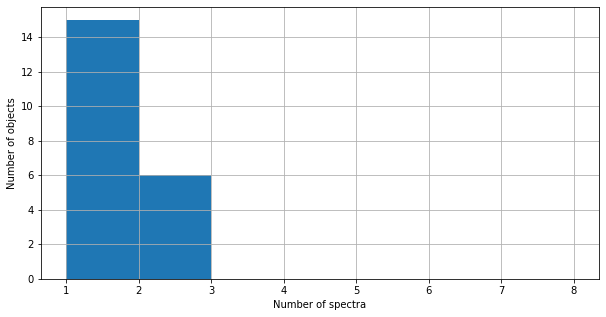

In [27]:
# Plot nspec distribution
fig, ax = plt.subplots(1,1, figsize=(10,5))
bg_qsos.index.value_counts().hist(bins=np.arange(1,9), ax=ax)
ax.set(xlabel='Number of spectra', ylabel='Number of objects');

In [28]:
# Creating a column which tells us how many spectra an object has, and appending it to original dataframe
bg_qsos['nspec'] = 0 # intialise an nspec column
for int_id, counts in bg_qsos.index.value_counts().iteritems():
    bg_qsos.loc[int_id, 'nspec'] = counts

/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/disk1/hrb/anaconda3/envs/astroconda/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [36]:
# How many objects have more than nspec number of spectra?
nspec = 1
subset = bg_qsos[bg_qsos['nspec']>=nspec]
print('There are {} quasars with {} or more spectra'.format(len(subset.index.unique()),nspec))
subset

There are 21 quasars with 1 or more spectra


,dist_arcsec,ra,dec,phot_bmag,pg_class,z,fiberID,plate,mjd,bestobjid,specobjid,nspec
pgq_id,,,,,,,,,,,,
12,0.163600,29.95938,0.394667,15.20,QSO,0.163490,550,403,51871,1237657071160262668,453888876696594432,2
12,0.100284,29.95938,0.394667,15.20,QSO,0.162808,1,9390,58103,1237657071160262668,10572200536077258752,2
20,0.052909,141.47800,19.901420,16.04,QSO,0.192696,130,2289,53708,1237667292116615199,2577220683100612608,2
20,0.061202,141.47800,19.901420,16.04,QSO,0.192095,212,9561,57809,1237667292116615199,10764787414453211136,2
28,0.133050,151.08390,5.216805,16.13,QSO,0.160116,4,995,52731,1237658422476144713,1120271552638642176,1
34,0.033060,156.38030,51.676360,16.12,Sey,0.044586,558,1008,52707,1237657590852681764,1135060533385390080,1
35,0.067012,162.93290,33.990750,15.81,QSO,0.167067,637,2025,53431,1237665129609756690,2280122466145691648,2
35,0.067289,162.93290,33.990750,15.81,QSO,0.167138,560,10268,58487,1237665129609756690,11560894317477515264,2
41,0.032849,169.27670,44.225920,16.05,QSO,0.143730,378,1365,53062,1237661851464499273,1536957328060868608,1


In [37]:
subset.to_csv('bg_spectra_nspec_1.csv')

In [17]:
# subset[['ra','dec','g','z','nspec','bestobjid']][~subset.index.duplicated(keep='first')].astype({col:'float32' for col in ['ra','dec','g','z']}).to_csv('data/nspec_2_meta.csv')
subset[['ra','dec','phot_bmag','z','nspec','bestobjid']][~subset.index.duplicated(keep='first')].astype({col:'float32' for col in ['ra','dec','phot_bmag','z']}).to_csv('data/nspec_2_meta.csv')

In [18]:
subset[['nspec','fiberID','plate','mjd']].to_csv('data/bg_nspec_2_spectra_data.csv')

In [124]:
subset[['ra','dec','phot_bmag','z','nspec','fiberID','plate','mjd']].astype({col:'float32' for col in ['ra','dec','phot_bmag','z']}).to_csv('data/bg_spectra_data.csv')

In [20]:
# bit suspicious about this one. Others are fine though.
# int_qsos.loc[152]

In [21]:
# trying to find mismatched objects. int_ids at the top of this list
# are likely to have multiple objects matched to it
# Have done this by look at the fractional range in the redshifts from their spectra
int_qsos.groupby('int_id').agg({'z':lambda x: np.ptp(x)/np.mean(x)}).sort_values('z',ascending=False)

KeyError: 'int_id'